In [ ]:
! pip install gradio

In [3]:
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
%matplotlib inline
from google.colab import drive
import gradio as gr


# connect to drive

In [4]:
# connect to drive 
drive.mount('/content/drive')

Mounted at /content/drive


# load the names of each image inside each of 2 folders .

In [5]:
base_path = '/content/drive/MyDrive/'

# get the name of each file in the images of folders no.
no_tumor_images=os.listdir(base_path+'no/')
# get the name of each file in the images of folders yes.
yes_tumor_images=os.listdir(base_path+'yes/')
# initialize dataset and label arrays
dataset=[]
label=[]
# set input size
INPUT_SIZE=64

In [6]:
#loop over each image in each category
for i , image_name in enumerate(no_tumor_images):
    #read the image if its extension is .jpg
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(base_path+'no/'+image_name)
       # image = Image.open('/content/drive/MyDrive/no'+image_name)

        image=Image.fromarray(image,'RGB')
        #resize the image
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        #append image arry in dataset list and its label in label list
        dataset.append(np.array(image))
        label.append(0)


In [7]:
#loop over each image in each category
for i , image_name in enumerate(yes_tumor_images):
    #read the image if its extension is .jpg
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(base_path+'yes/'+image_name)
       # image = Image.open('/content/drive/MyDrive/no'+image_name)

        image=Image.fromarray(image,'RGB')
        #resize the image
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        #append image arry in dataset list and its label in label list
        dataset.append(np.array(image))
        label.append(1)


In [8]:
# convert image into numpy array 
dataset=np.array(dataset)
# convert label into numpy array  
label=np.array(label)

# vistualization of images.

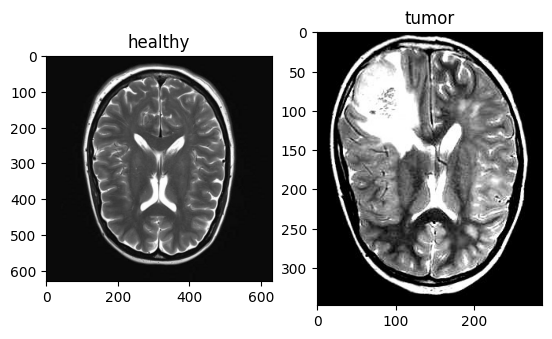

In [9]:
# Set the path to the image file on your Google Drive
image_path1 = '/content/drive/MyDrive/no/No12.jpg'
image_path2='/content/drive/MyDrive/yes/y0.jpg'
# Open the image file using PIL
image = Image.open(image_path1)
image2 = Image.open(image_path2)

# Compute the histograms of the images
#hist1 = image.histogram()
#hist2 = image2.histogram()

# Create a figure with two rows and two columns
fig, axs = plt.subplots(1, 2)

# Display the images in the first row
axs[0].imshow(image)
axs[0].set_title('healthy')
axs[1].imshow(image2)
axs[1].set_title('tumor')

# Plot the histograms in the second row
#axs[1, 0].plot(hist1)
#axs[1, 1].plot(hist2)

# Show the figure
plt.show()

# Display the image
#image.show()

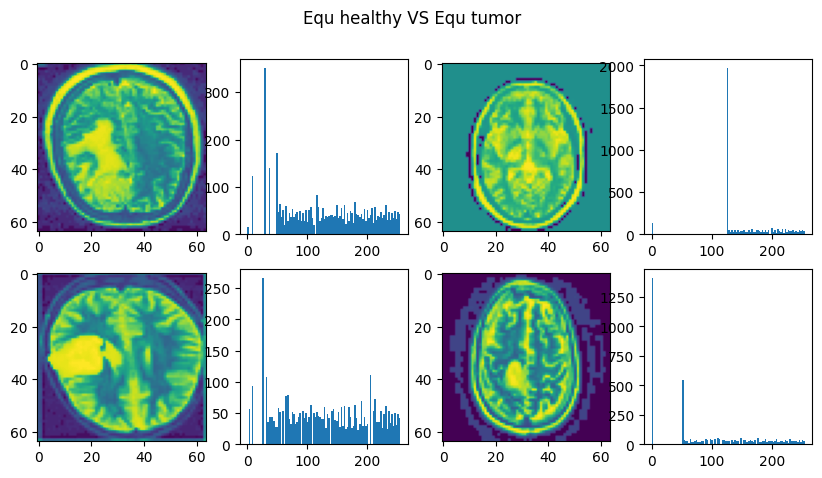

<Figure size 640x480 with 0 Axes>

In [10]:
# Initialise the subplots using number of rows and columns
figure, axis = plt.subplots(2, 4)
#custom layout
figure.set_figheight(5)
figure.set_figwidth(10)

def ploty (row,col,idx):
    
    """
    Function takes the row, col of figure, idx of image 
    to plot LAB image, its hist of l
    """
   
    
    img = cv2.cvtColor(dataset[idx],cv2.COLOR_BGR2LAB)
    b,g,r = cv2.split(img)
    equ = cv2.equalizeHist(b)
    axis[row,col].imshow(equ)
        
    axis[row,col+1].hist(equ.flat, bins=100, range=(0,255))
# image from first half (not affected)
ploty(0,0,2000)
# image from second (affected)
ploty(1,0,2200)
ploty(0,2,600)
ploty(1,2,2600)
figure.suptitle("Equ healthy VS Equ tumor")
plt.show()
plt.savefig('equ.png')

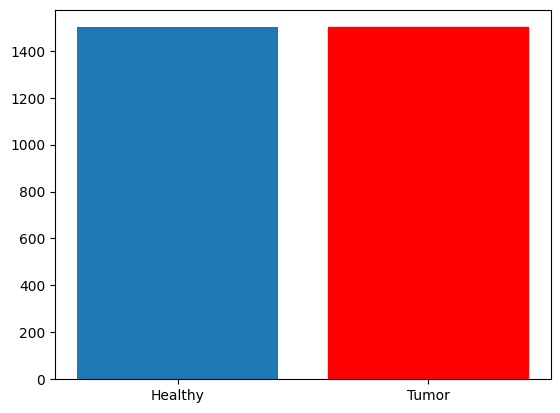

In [11]:
# make the distribution of healthy and tumor persons.
from collections import Counter 
# counts the number of occures of each label and save them in a dictionary
c = Counter(label)
#rename the keys and delete the old one
c["Healthy"] = c[0]
del c[0]
c['Tumor'] = c[1]
del c[1]
#plot each key and value in c 
plot=plt.bar(c.keys(), c.values())
plot[1].set_color('r')

plt.savefig('DataDistribution.png')

# model

In [12]:
# split the datat into trainig and testing .
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.2, random_state = 42)

In [13]:
# print hte shape of train data or dimensions of labels.
print(x_train.shape) 
# print hte shape of train data or dimensions of labels.
print(y_train.shape) 

(2400, 64, 64, 3)
(2400,)


In [14]:
# Normalise the data for training purpose to make values similar intensities.
x_train = normalize( x_train, axis =1)
x_test = normalize( x_test, axis =1)

In [15]:
# Building a simple CNN model
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape = (INPUT_SIZE, INPUT_SIZE, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3),  kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
#model.add(Dense(2))
model.add(Activation('sigmoid'))
# model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 29, 29, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                    

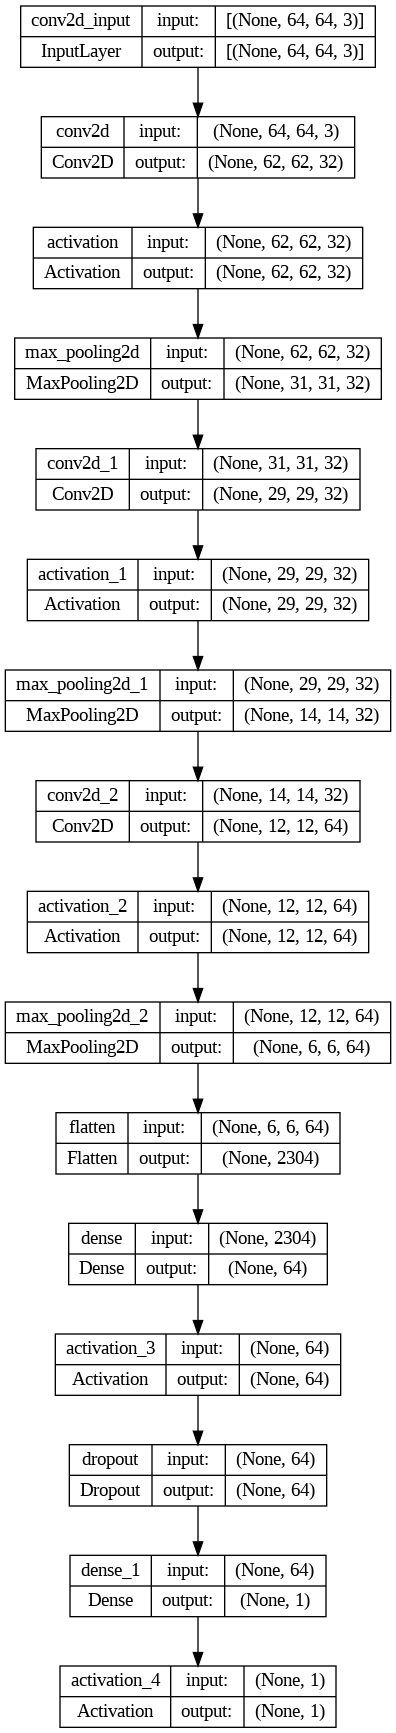

In [16]:
tf.keras.utils.plot_model(model,
                          to_file="model.png",
                          show_shapes=True,
                          expand_nested=True)

In [17]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [18]:
model.fit(x_train, y_train, 
batch_size = 16, 
verbose = 1, epochs = 15, 
validation_data = (x_test, y_test),
shuffle = 'False')

Epoch 1/15
150/150 [==============================] - 17s 102ms/step - loss: 0.5604 - accuracy: 0.7125 - val_loss: 0.4585 - val_accuracy: 0.7900
Epoch 2/15
150/150 [==============================] - 15s 98ms/step - loss: 0.4272 - accuracy: 0.8142 - val_loss: 0.3738 - val_accuracy: 0.8267
Epoch 3/15
150/150 [==============================] - 15s 98ms/step - loss: 0.3188 - accuracy: 0.8754 - val_loss: 0.2736 - val_accuracy: 0.8950
Epoch 4/15
150/150 [==============================] - 20s 136ms/step - loss: 0.2309 - accuracy: 0.9125 - val_loss: 0.2057 - val_accuracy: 0.9350
Epoch 5/15
150/150 [==============================] - 15s 99ms/step - loss: 0.1447 - accuracy: 0.9496 - val_loss: 0.1561 - val_accuracy: 0.9467
Epoch 6/15
150/150 [==============================] - 14s 95ms/step - loss: 0.1072 - accuracy: 0.9658 - val_loss: 0.1692 - val_accuracy: 0.9333
Epoch 7/15
150/150 [==============================] - 15s 99ms/step - loss: 0.0753 - accuracy: 0.9796 - val_loss: 0.1314 - val_accurac

In [19]:
model.save('Brain Tumor detection.h5')


In [20]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.13506008684635162
Test accuracy: 0.9633333086967468


In [21]:
classes=np.unique(label)
classes

array([0, 1])

# image preprocessing

## image compresion

In [60]:
import gradio as gr
from PIL import Image

def compression(img):
    # Compress the image by saving it with the optimize parameter set to True to compress it
    # and adjusting the quality parameter
    img.save("compressed_image.jpg", "JPEG", optimize=True, quality=70)
    return Image.open("compressed_image.jpg")

iface = gr.Interface(
    fn=compression,
    inputs=gr.inputs.Image(type='pil', label="Input Image"),
    outputs=gr.outputs.Image(type='pil', label="Compressed Image")
)

# Launch the app
iface.launch()


/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

## image enhancement

In [22]:
def enhance_noise(img):
    ksize = (7, 7) # kernel size (width, height)
    sigma1 = 1 # standard deviation for first Gaussian filter
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply a gaussian blur to reduce noise
    blur1 = cv2.GaussianBlur(gray, ksize, sigma1)
    # Convert the image back to RGB
    enhanced = cv2.cvtColor(blur1, cv2.COLOR_GRAY2BGR)
    return enhanced

iface = gr.Interface(
    fn=enhance_noise,
    inputs=gr.inputs.Image(type='numpy'),
    outputs=gr.outputs.Image(type='pil')
)
# Launch the app
iface.launch()


/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

# image upsampling

In [67]:
import imageio
import gradio as gr
import cv2
import numpy as np

def image_upsampling(img):
    # Convert the input image to a numpy array
    img = np.array(img)
    
    # Calculate the new size of the image
    new_width = img.shape[1] * 3
    new_height = img.shape[0] * 3

    # Perform image upsampling using the resize function
    upsampled_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_NEAREST)

    # Return the upsampled image
    return upsampled_img

iface = gr.Interface(
    fn=image_upsampling,
    inputs=gr.inputs.Image(label="Input Image"),
    outputs=gr.outputs.Image(label="Upsampled Image",type='numpy')
)

# Launch the app
iface.launch()


/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

## image detection

In [64]:
import cv2
import gradio as gr

def edge_segmentation(input_image):
    # Load the image
  #  image = cv2.imread(input_image)
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    
    # Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)
    
    # Apply a bit-wise AND to get the original image with the edges highlighted
    segmented_image = cv2.bitwise_and(input_image, input_image, mask=edges)
    
     #Convert the segmented image back to RGB for display
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)
  

    
    return segmented_image

# Define the Gradio interface
inputs = gr.inputs.Image(label="Input Image")
outputs = gr.outputs.Image(type="numpy", label="Segmented Image")

gr_interface = gr.Interface(fn=edge_segmentation, inputs=inputs, outputs=outputs, 
                           title="Edge Segmentation", description="Detect edges in an image")

# Start the Gradio interface
gr_interface.launch()

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

## image segmentation

In [54]:
import cv2
import gradio as gr
from PIL import Image
import numpy as np

def cancer_segmentation(input_image):
    try:
        

        # Convert the image to grayscale
        gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

        # Apply Canny edge detection
        edges = cv2.Canny(gray, 100, 200)

        # Apply thresholding to convert cancerous regions to white
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Invert the binary image
        binary = cv2.bitwise_not(binary)

        # Create a mask using the edges and the binary image
        mask = cv2.bitwise_or(edges, binary)

        # Create a black image with the same shape as the original image
        segmented_image = np.zeros_like(input_image)

        # Set the cancerous regions to white in the segmented image
        segmented_image[mask > 0] = [255, 255, 255]

        # Convert NumPy array to PIL Image
        segmented_image = Image.fromarray(segmented_image)

        return segmented_image
    except Exception as e:
        print("Error occurred:", str(e))
        return None

# Define the Gradio interface
inputs = gr.inputs.Image(label="Input Image")
outputs = gr.outputs.Image(type="pil", label="Segmented Image")

gr_interface = gr.Interface(fn=cancer_segmentation, inputs=inputs, outputs=outputs, 
                           title="Cancer Segmentation", description="Detect and highlight cancerous regions")

# Start the Gradio interface
gr_interface.launch()

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

## image prediction

In [32]:
def prediction(img):
 # image = cv2.imread('/kaggle/input/brain-tumor-detection/pred/pred43.jpg') #tumor detected 
  img = Image.fromarray(img)
  img = img.resize((64,64))
  img = np.array(img)
  input_img = np.expand_dims(img, axis=0)
  result = model.predict(input_img)
 # return {classes[i] : float(result[i]) for i in range(2)}
  return int(result[0][0] > 0.5)




iface = gr.Interface(
    fn=prediction,
    inputs=gr.inputs.Image(shape=(224, 224)),
    outputs=gr.outputs.Label(num_top_classes=2),
    capture_session=True
)
iface.launch()

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)
<ipython-input-32-c9dd200d1ffd>:14: UserWarning: `capture_session` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>